In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tsmoothie.smoother import GaussianSmoother
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as sp
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as qm
import helper_functions as helper

In [2]:
#Reading the file, BP filtering
local_path= '/mnt/disk15tb/jonathan/Syngap3/Syngap3/230109/16940/Network/000200/data.raw.h5' #network data from chip 16848

recording1 = se.read_maxwell(local_path)



#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=300, freq_max=6000)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=300*fs)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")


Sampling frequency: 20000.0
Number of channels: 1002
Number of segments: 1
total_recording: 300.1 s
chunk duration: 300.0 s


In [ ]:
default_KS2_params = ss.get_default_sorter_params('kilosort2')
print(default_KS2_params)

In [ ]:

default_KS2_params['keep_good_only'] = True
default_KS2_params['detect_threshold'] = 12
default_KS2_params['projection_threshold']=[18, 10]
default_KS2_params['preclust_threshold'] = 8
run_sorter = ss.run_kilosort2(recording_chunk, output_folder="/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/Syngap3/KS_230109_16940/", docker_image= "kilosort2-maxwellcomplib:latest",verbose=True, **default_KS2_params)
#run_sorter = ss.run_sorter('kilosort2',recording= recording_chunk, output_folder="/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/kilosort2",docker_image= True,verbose=True, **default_KS2_params)

In [3]:
sorting_KS3 = ss.Kilosort2Sorter._get_result_from_folder('/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/Syngap3/KS_230109_16940/sorter_output')
total_units = sorting_KS3.get_unit_ids()
#print(total_units)
#print(len(total_units))
channel_ids = recording_chunk.get_channel_ids()
print(channel_ids)


['0' '1' '2' ... '1021' '1022' '1023']


In [4]:
channel_association_dict = {int(y):x for x,y in enumerate(channel_ids) }
print(channel_association_dict)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99, 100: 100, 101: 101, 102: 102, 103: 103, 104: 104, 105: 105, 106: 106, 107: 107, 108: 108, 109: 109, 110: 110, 111: 111, 112: 112, 113: 113, 114: 114, 115: 115, 116: 116, 117: 117, 118: 118, 119: 119, 120: 120, 121: 121,

In [5]:
sorting_good = sorting_KS3.remove_empty_units()

In [6]:
sorting_good = spikeinterface.curation.remove_excess_spikes(sorting_good,recording_chunk)

In [ ]:
job_kwargs = dict(n_jobs=64, chunk_duration="1s", progress_bar=True)
#waveforms = si.extract_waveforms(recording_chunk,sorting_KS3,folder="./waveformsblock1_7min",overwrite=True, ms_before=1., ms_after=2.,**job_kwargs)
waveforms = si.extract_waveforms(recording_chunk,sorting_good,folder='/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/Syngap3/waveform_230109_16940/',overwrite=True)
print(waveforms)

In [7]:
waveforms = si.load_waveforms('/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/Syngap3/waveform_230109_16940/')
print(waveforms)

WaveformExtractor: 1002 channels - 359 units - 1 segments
  before:60 after:80 n_per_units:500


In [8]:
job_kwargs = dict(n_jobs=64, chunk_duration="1s", progress_bar=True)
sp.compute_spike_amplitudes(waveforms,load_if_exists=True,**job_kwargs)

[memmap([-100.70801 ,  -44.059753,  -12.588501, ...,  -25.177002,
         -100.70801 , -119.59076 ], dtype=float32)]

In [9]:
import spikeinterface.qualitymetrics as qm
job_kwargs = dict(n_jobs=64, chunk_duration="1s", progress_bar=True)
metrics = qm.compute_quality_metrics(waveforms,load_if_exists=True,**job_kwargs)

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
display(metrics)

In [ ]:
import os
import fnmatch

def find_files_with_subfolder(root_dir, file_name_pattern, subfolder_name):
    file_paths = []
    for dirpath, _, filenames in os.walk(root_dir):
        if subfolder_name in dirpath.split(os.path.sep):
            for filename in fnmatch.filter(filenames, file_name_pattern):
                file_paths.append(os.path.join(dirpath, filename))
    return file_paths

if __name__ == "__main__":
    root_directory = "/mnt/disk15tb/jonathan/Syngap3"
    file_name_pattern = "data.raw.h5"
    subfolder_name = "Network"
    
    result = find_files_with_subfolder(root_directory, file_name_pattern, subfolder_name)
    
    if result:
        print("Found the file in the following locations:")
        for path in result:
            print(path)
    else:
        print("The file was not found in any subdirectory named 'Network.'")


In [11]:
import mea_analysis_pipeline as msp
unit_ids = msp.remove_violated_units(metrics)
print(f"{unit_ids} {len(unit_ids)}")

[  1   4   7  13  14  16  23  25  26  28  30  33  41  42  51  64  65  70
  71  77  82  90  96 100 101 102 114 119 120 124 126 127 129 130 132 143
 144 151 160 161 165 166 168 178 186 194 196 198 202 208 209 210 214 217
 219 221 223 225 232 234 235 236 238 248 258 259 261 264 266 271 274 282
 283 286 296 302 303 305 310 311 315 327 329 330 332 337 344 346 348 357
 365 383 385 388 390 391 392 395 402 418 419 423 425 426 428 432 434 435
 438 456 458 461 467 472 480 495 506 511 517 527 534 550 552 554 555 557
 559 560 563 565 566 577 585 586 587 588 595 598 599 601 604] 141


In [ ]:
template_metrics = sp.compute_template_metrics(waveforms)
display(template_metrics)
template_metrics.to_excel('template_metrics.xlsx',index=False)

In [12]:
extremum_electrodes = si.get_template_extremum_channel(waveforms)
print(extremum_electrodes)

{1: '2', 3: '3', 4: '4', 5: '7', 7: '13', 9: '17', 11: '28', 12: '28', 13: '29', 14: '30', 15: '31', 16: '50', 23: '44', 24: '45', 25: '48', 26: '50', 28: '52', 29: '672', 30: '55', 31: '57', 32: '59', 33: '61', 34: '67', 35: '69', 36: '70', 41: '77', 42: '81', 44: '85', 48: '89', 49: '89', 51: '94', 53: '97', 57: '103', 60: '105', 62: '106', 64: '108', 65: '110', 67: '115', 68: '118', 70: '120', 71: '121', 72: '123', 74: '131', 77: '134', 78: '135', 79: '135', 80: '136', 82: '137', 84: '141', 85: '142', 89: '149', 90: '150', 92: '160', 96: '165', 98: '173', 100: '177', 101: '179', 102: '188', 104: '191', 105: '194', 106: '195', 107: '197', 109: '201', 110: '205', 111: '206', 112: '209', 113: '210', 114: '211', 117: '218', 119: '223', 120: '225', 123: '229', 124: '230', 126: '238', 127: '241', 129: '243', 130: '244', 132: '260', 133: '263', 135: '264', 139: '271', 140: '273', 141: '274', 142: '277', 143: '278', 144: '281', 146: '283', 147: '283', 149: '287', 150: '288', 151: '289', 153

In [ ]:
extremum_electrodes ={key:value for key,value in extremum_electrodes.items() if key in unit_ids}

In [ ]:
print(extremum_electrodes)
print(len(extremum_electrodes))

In [ ]:
channel_location_dict = msp.get_channel_locations_mapping(recording_chunk)
print(channel_location_dict)
# New dictionary with combined information
electrodes = []

# Iterate over each template in the template_channel_dict dictionary
for template, channel in extremum_electrodes.items():



    # Add an entry for this template and its corresponding location to the new dictionary
    electrodes.append(220* int(channel_location_dict[channel][1]/17.5)+int(channel_location_dict[channel][0]/17.5))



In [ ]:
print(electrodes)

In [ ]:
import pickle

with open('electrodes.pkl')

In [14]:
redundant_units = msp.remove_similar_templates(waveforms)
print(f"redundant-units : {redundant_units}")
non_violated_units = [item for item in unit_ids if item not in redundant_units]

462 259
599 420
redundant-units : [259, 599]


In [13]:
sorting_auto_KS3 = sorting_KS3.select_units(unit_ids)

In [ ]:
waveform_good = waveforms.select_units(non_violated_units,new_folder='/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/Syngap3/waveform_230109_16940_good')


In [15]:
waveform_good = si.load_waveforms('/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/Syngap3/waveform_230109_16940_good')

In [16]:
job_kwargs = dict(n_jobs=64, chunk_duration="1s", progress_bar=True)
sp.compute_spike_amplitudes(waveform_good,load_if_exists=True,**job_kwargs)

[memmap([-100.70801 ,  -44.059753,  -12.588501, ...,  -81.82526 ,
          -25.177002, -119.59076 ], dtype=float32)]

In [17]:
metrics = qm.compute_quality_metrics(waveform_good,load_if_exists=True,**job_kwargs)
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
display(metrics)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median
1,1183.0,3.943333,1.0,inf,0.000000,0.0,0.000000,0.0,0.145,0.003918,151.062010
4,738.0,2.460000,1.0,inf,0.000000,0.0,0.000000,0.0,0.225,0.005993,44.059753
7,1058.0,3.526667,1.0,inf,0.000000,0.0,0.000000,0.0,0.155,0.006720,245.475770
13,1318.0,4.393333,1.0,inf,0.000000,0.0,0.000000,0.0,0.115,0.000562,113.296510
14,824.0,2.746667,1.0,inf,0.000000,0.0,0.000000,0.0,0.110,0.000329,88.119510
16,1503.0,5.010000,1.0,inf,0.000000,0.0,0.000000,0.0,0.080,0.008211,62.942505
23,2392.0,7.973333,1.0,inf,0.000000,0.0,0.000000,0.0,0.010,0.000895,37.765503
25,605.0,2.016667,1.0,inf,0.273205,1.0,0.000000,0.0,NaN,0.043374,176.239010
26,2125.0,7.083333,1.0,inf,0.000000,0.0,0.000000,0.0,0.045,0.010965,528.717040
28,1036.0,3.453333,1.0,inf,0.093171,1.0,0.000000,0.0,0.055,0.006278,69.236755


In [50]:
metrics.describe()

/home/mmp/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median
count,139.000000,139.000000,139.0,139.0,139.000000,139.000000,139.000000,139.000000,90.000000,139.000000,139.000000
mean,1087.604317,3.625348,1.0,inf,0.074154,0.669065,0.040198,0.208633,0.156500,0.008327,162.337324
std,762.312031,2.541040,0.0,NaN,0.152241,1.746170,0.164469,0.912671,0.102917,0.014245,100.831864
min,509.000000,1.696667,1.0,inf,0.000000,0.000000,0.000000,0.000000,0.010000,0.000221,6.294251
25%,648.500000,2.161667,1.0,NaN,0.000000,0.000000,0.000000,0.000000,0.061250,0.001296,81.825260
50%,845.000000,2.816667,1.0,NaN,0.000000,0.000000,0.000000,0.000000,0.157500,0.002723,151.062010
75%,1179.500000,3.931667,1.0,NaN,0.075983,1.000000,0.000000,0.000000,0.246250,0.007403,214.004520
max,5565.000000,18.550000,1.0,inf,0.846332,14.000000,1.000000,9.000000,0.340000,0.083733,528.717040


In [ ]:
sw.plot_unit_summary(waveform_good,unit_id=560)

In [20]:
channel_ids = recording_chunk.channel_ids
indices = waveform_good.channel_ids_to_indices(channel_ids)
channel_locations = waveform_good.get_channel_locations()[waveform_good.channel_ids_to_indices(channel_ids)]
print(indices)

[   0    1    2 ...  999 1000 1001]


In [21]:
extremum_channels = sp.get_template_extremum_channel(waveform_good)
print(extremum_channels)

{1: '2', 4: '4', 7: '13', 13: '29', 14: '30', 16: '50', 23: '44', 25: '48', 26: '50', 28: '52', 30: '55', 33: '61', 41: '77', 42: '81', 51: '94', 64: '108', 65: '110', 70: '120', 71: '121', 77: '134', 82: '137', 90: '150', 96: '165', 100: '177', 101: '179', 102: '188', 114: '211', 119: '223', 120: '225', 124: '230', 126: '238', 127: '241', 129: '243', 130: '244', 132: '260', 143: '278', 144: '281', 151: '289', 160: '310', 161: '313', 165: '321', 166: '325', 168: '333', 178: '344', 186: '374', 194: '385', 196: '387', 198: '390', 202: '400', 208: '406', 209: '406', 210: '410', 214: '416', 217: '420', 219: '422', 221: '428', 223: '430', 225: '436', 232: '453', 234: '458', 235: '459', 236: '460', 238: '461', 248: '475', 258: '491', 261: '495', 264: '500', 266: '505', 271: '515', 274: '518', 282: '529', 283: '534', 286: '537', 296: '548', 302: '556', 303: '557', 305: '559', 310: '560', 311: '564', 315: '569', 327: '593', 329: '595', 330: '597', 332: '601', 337: '608', 344: '622', 346: '624'

In [ ]:
template_amplitudes = sp.get_template_amplitudes(waveform_good)

In [ ]:

print(template_amplitudes[0].shape)

In [ ]:
template_waveforms = waveform_good.get_template([0])

In [ ]:
print(template_waveforms.shape)

In [51]:
metrics.to_excel('metrics.xlsx',index=False)

In [ ]:
metrics.describe()

In [52]:
template_metrics = sp.compute_template_metrics(waveform_good)

In [53]:
display(template_metrics)
template_metrics.to_excel('template_metrics.xlsx',index=False)

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope
1,0.00033,-0.19486,0.00015,679400.882574,-33941.366584
4,0.00034,-0.176187,0.00014,335833.932482,-9348.547159
7,0.000305,-0.24393,0.000165,1445263.663201,-73257.240755
13,0.00027,-0.186892,0.00014,1085475.168359,-24698.210476
14,0.000575,-0.229663,0.00027,216188.375831,-27180.38337
16,0.00036,-0.253857,0.00025,751192.851514,-33941.718752
23,0.000525,-0.116146,0.000155,188579.35615,-6316.280203
25,0.00034,-0.207033,0.00016,810904.302633,-49173.326946
26,0.000285,-0.167826,0.000145,3335376.478903,-80783.256327
28,0.00032,-0.369377,0.00018,489315.53091,-60776.862915


In [ ]:
%matplotlib widget
locations = sp.compute_unit_locations(waveform_good)
print(len(locations))




In [ ]:
import pickle

file_path = './Firingratelocation.pkl'

with open(file_path,'wb') as file:
    pickle.dump(locations,file)

In [ ]:
unit_extremum_channel =spikeinterface.full.get_template_extremum_channel(waveform_good, peak_sign='neg')
#Step 1: keep only units that are in good_units 
unit_extremum_channel = {key:value for key,value in unit_extremum_channel.items() }
print(f"extremum channel : {unit_extremum_channel}")

#unique channels and count:
unique_channel_count = set([value for key,value in unit_extremum_channel.items()])
print(f"{unique_channel_count} and len : {len(unique_channel_count)}")

#Step3: get units that correspond to same electrodes.
output_units = [[key for key, value in unit_extremum_channel.items() if value == v] for v in set(unit_extremum_channel.values()) if list(unit_extremum_channel.values()).count(v) > 1]
print(f"Units that correspond to same electrode: {output_units}")

In [ ]:
print(type(metrics['amplitude_median'][int('0')]))

In [ ]:
my_list = [[5, 11], [9, 19, 27], [46, 48], [1, 2, 3], [50, 53, 59], [17, 18]]

# Flatten the list using a nested list comprehension
flattened_list = [element for sublist in my_list for element in sublist]

print(flattened_list)

In [ ]:
extremum_channels_ids =spikeinterface.full.get_template_extremum_channel(waveforms, peak_sign='neg')
print(extremum_channels_ids)



In [ ]:

output = [[key for key, value in extremum_channels_ids.items() if value == v] for v in set(extremum_channels_ids.values()) if list(extremum_channels_ids.values()).count(v) > 1]
print(output)

In [ ]:


print(helper.get_key_by_value(extremum_channels_ids,'221'))

In [ ]:

isi_violations_ratio, isi_violations_count = qm.compute_isi_violations(waveforms, isi_threshold_ms=1.0)
print(isi_violations_ratio)
print(isi_violations_count)

rp_contamination,rp_violation = qm.compute_refrac_period_violations(waveforms)
print(rp_contamination)
print(rp_violation)
snr_ratio = qm.compute_snrs(waveforms,peak_sign="both", peak_mode='at_index')
print(snr_ratio)

firing_rate = qm.compute_firing_rates(waveforms)
print(firing_rate)

amp_cutoff = qm.compute_amplitude_cutoffs(waveforms)
print(amp_cutoff)

In [ ]:
for i in range(29):
    record_num = str(i).zfill(4)
    record_name = 'rec' + record_num
    print(record_name)

In [ ]:
import helper_functions as helper


filename = 'Extremechannels_4min.json'
helper.dumpdicttofile(extremum_channels_ids,filename)


In [ ]:
violated_units = [unit for unit, ratio in isi_violations_ratio.items() if ratio > 0.0]
print(violated_units)
print(f"isi violated units:{len(violated_units)}")

refrct_violated_units = [unit for unit,ratio in rp_contamination.items() if ratio >0.0]
print(refrct_violated_units)
print(f"refract vio units:{len(refrct_violated_units)}")

In [ ]:
frrate_units = [ unit for unit,ratio in firing_rate.items() if ratio < 0.1]
print(frrate_units)

In [ ]:
deletion_candidates = list(set(violated_units+frrate_units))
print(deletion_candidates)

In [ ]:
print(sorting_KS3)

clean_sorting = sorting_KS3.remove_units(deletion_candidates)
print(clean_sorting)
good_units = [units for units in total_units if units not in deletion_candidates ]
print(good_units)

#now getting the wavefrom extractor

waveform_good = waveforms.select_units(good_units,new_folder='/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/waveforms_good')
print(waveform_good)

In [ ]:
unit_extremum_channel =sp.get_template_extremum_channel(waveforms, peak_sign='neg')
#Step 1: keep only units that are in good_units 
print(unit_extremum_channel)
unit_extremum_channel = {key:value for key,value in unit_extremum_channel.items() if key  in good_units}

print(unit_extremum_channel)
#Step3: get units that correspond to same electrodes.
output_units = [[key for key, value in unit_extremum_channel.items() if value == v] for v in set(unit_extremum_channel.values()) if list(unit_extremum_channel.values()).count(v) > 1]

print(output_units)
output=[]
if output_units :
    for sublist in output_units :
        amp_max = 0 
        for unit in sublist:
            if metrics['amplitude_median'][int(unit)] > amp_max :
                amp_max = metrics['amplitude_median'][int(unit)]
                reqd_unit = unit
        output.append(reqd_unit)
#Step 5 --> unit_extremum_channel - output_units + output
output_units = [element for sublist in output_units for element in sublist]
new_list = [ item for item in output_units if item not in output]

print(f"Output : {output}")

print(f"Output units : {output_units}")

print(f"new list {new_list}")
required_templates = {key:value for key,value in unit_extremum_channel.items() if key not in new_list}
print(f"reqd templates {required_templates}")

In [ ]:
%matplotlib widget

In [ ]:


locations = sp.compute_unit_locations(waveforms)
print(type(locations))

#np.savetxt("unitloc_10mins.txt",locations)
ax = plt.subplot(111)
sw.plot_probe_map(recording1,ax=ax,with_channel_ids=False)
for x,y in locations:
    ax.scatter(x,y)

In [ ]:
import spikeinterface_gui
app = spikeinterface_gui.mkQApp() 

# create the mainwindow and show
win = spikeinterface_gui.MainWindow(waveforms)
win.show()
# run the main Qt6 loop
app.exec_()#Need to implement compute noise levels.

In [ ]:
channel_locations = recording_chunk.get_channel_locations()
channel_ids = recording_chunk.get_channel_ids()
_ = [print(f"{channel_id}: {location}") for location, channel_id in zip(channel_locations, channel_ids)]



In [ ]:
fig, ax1 = plt.subplots(figsize=(15,5))
spike_times = {}
for idx, unit_id in enumerate(clean_sorting.get_unit_ids()):
    spike_train = clean_sorting.get_unit_spike_train(unit_id,start_frame=1*fs,end_frame=100*fs)
    print(spike_train)
    if len(spike_train) > 0:
        spike_times[idx] = spike_train / float(fs)
        #print(spike_times[unit_id])
       # print(unit_id*np.ones_like(spike_times[unit_id]))
        ax1.plot(spike_times[idx],idx*np.ones_like(spike_times[idx]),
                             marker='|', mew=1, markersize=3,
                             ls='',color='black')
                       

In [ ]:
t_start = 0 
t_end = int(600*fs)
dt = 1
#initialising the spike train.
units= clean_sorting.get_num_units()
frame_numbers = t_end
spike_array = np.zeros((units,frame_numbers), dtype= int)
for idx, unit_id in enumerate(clean_sorting.get_unit_ids()):
    spike_train = clean_sorting.get_unit_spike_train(unit_id,start_frame=t_start,end_frame=t_end)
    for spike_time in spike_train:
        spike_array[idx,spike_time] = 1

print(spike_array)

print(spike_array[0,63782])

In [ ]:
np.savez_compressed('spike_array_compressed_blockactivity.npz',spike_array)

In [ ]:
with np.load('spike_array_compressed_blockactivity.npz') as data:
    decompressed_data = data['arr_0']

print(np.array_equal(spike_array, decompressed_data))


In [ ]:

extremum_channels_ids =sp.get_template_extremum_channel(waveform_good,peak_sign ='both',mode='at_index')
print(extremum_channels_ids)



In [ ]:
print(channel_association_dict)

In [ ]:
colors = [ 'Lime','Gold', 'Orange','Orangered']
fig, ax = plt.subplots()
wf=[]
for i, unit_id in enumerate([22,20]):
    wf = waveforms.get_waveforms(unit_id)
    color = colors[i]
    ax.plot(wf[:, :,channel_association_dict[29]].T, color=color, lw=0.3)
print(wf.shape)

In [ ]:
colors = [ 'Fuchsia','Olive', 'Teal']
fig, ax = plt.subplots()
wf=[]
for i, unit_id in enumerate([143]):
    wf = waveform_good.get_waveforms(unit_id)
    ax.plot(wf[:, :,channel_association_dict[732]].T, color=colors[0], lw=0.3)

print(wf.shape)

In [ ]:
peak_shift=si.get_template_extremum_channel_peak_shift(waveform_good)

print(peak_shift)

In [23]:
print(extremum_channels)

{1: '2', 4: '4', 7: '13', 13: '29', 14: '30', 16: '50', 23: '44', 25: '48', 26: '50', 28: '52', 30: '55', 33: '61', 41: '77', 42: '81', 51: '94', 64: '108', 65: '110', 70: '120', 71: '121', 77: '134', 82: '137', 90: '150', 96: '165', 100: '177', 101: '179', 102: '188', 114: '211', 119: '223', 120: '225', 124: '230', 126: '238', 127: '241', 129: '243', 130: '244', 132: '260', 143: '278', 144: '281', 151: '289', 160: '310', 161: '313', 165: '321', 166: '325', 168: '333', 178: '344', 186: '374', 194: '385', 196: '387', 198: '390', 202: '400', 208: '406', 209: '406', 210: '410', 214: '416', 217: '420', 219: '422', 221: '428', 223: '430', 225: '436', 232: '453', 234: '458', 235: '459', 236: '460', 238: '461', 248: '475', 258: '491', 261: '495', 264: '500', 266: '505', 271: '515', 274: '518', 282: '529', 283: '534', 286: '537', 296: '548', 302: '556', 303: '557', 305: '559', 310: '560', 311: '564', 315: '569', 327: '593', 329: '595', 330: '597', 332: '601', 337: '608', 344: '622', 346: '624'

In [32]:
print(recording_chunk.channel_ids)

['0' '1' '2' ... '1021' '1022' '1023']


(140, 1002)
1021
[999]


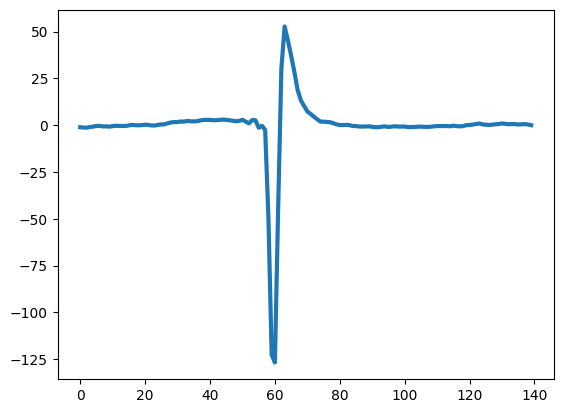

In [43]:




fig, ax = plt.subplots()
for i, unit_id in enumerate([595]):
    
    template = waveform_good.get_template(unit_id)
    print(template.shape)
    print(int(extremum_channels[unit_id]))
    number = waveform_good.channel_ids_to_indices([str(int(extremum_channels[unit_id]))])
    print(number)
    ax.plot(template[:, number[0]].T, lw=3)
  


In [ ]:
%matplotlib widget
sw.plot_unit_templates(waveform_good,unit_ids=[73])

In [ ]:
trough = min(template[:,channel_association_dict[number]])
peak = max(template[:,channel_association_dict[number]])
peak_index = np.where(template[:,channel_association_dict[number]]==peak)[0]
trough_index = np.where(template[:,channel_association_dict[number]]==trough)[0]
trough_to_peak = (peak_index-trough_index)[0]
#index at half peak. 
half_peak_index = np.where(template[:,channel_association_dict[number]]<=0.5*peak)
half_peak_index= half_peak_index[0][np.where(half_peak_index[0]>peak_index)[0][0]]
repol_time = half_peak_index - peak_index[0]


In [ ]:
waveform_good.unit_ids

In [46]:
def get_channel_association_dict(recording):
    """
    Takes in recording object and gives a channel association dict.
    
    """
    channel_ids = recording.get_channel_ids()

    return {int(y):x for x,y in enumerate(channel_ids) }

def get_template_characteristics(waveforms):

    """
    returns a pd dataframe of unit templates and their characterisitcs Amplitude, trough to peak time, repolarisation time.

    """

    #get unit ids in the waveform object

    unit_ids = waveforms.unit_ids
    #get extremum channels
    extremum_channels_ids =spikeinterface.full.get_template_extremum_channel(waveform_good, peak_sign='both')

    df = []
    for unit_id in unit_ids:
        
        template = waveforms.get_template(unit_id)

        template_segment = template[:,waveforms.channel_ids_to_indices([str(int(extremum_channels[unit_id]))])]
        trough = min(template_segment)
        peak = max(template_segment)
        peak_index = np.where(template_segment==peak)[0]
        trough_index = np.where(template_segment==trough)[0]
        trough_to_peak = (peak_index-trough_index)[0]
        #index at half peak. 
        half_peak_index = np.where(template_segment<=0.5*peak)
        half_peak_index_2= half_peak_index[0][np.where(half_peak_index[0]>peak_index)[0][0]]
        repol_time = half_peak_index_2 - peak_index[0]
        data = {"Unit": unit_id,"Amp":trough[0],"TTP":trough_to_peak,"REP":repol_time}
        df.append(data)
    df = pd.DataFrame(df)
    return df
        
    

In [47]:

data= get_template_characteristics(waveform_good)
print(data)

     Unit         Amp  TTP  REP
0       1 -143.433548    6    5
1       4  -41.806450    7    4
2       7 -242.656128    7    5
3      13 -109.583015    6    4
4      14  -85.853729   12    6
5      16 -142.892075    7    5
6      23  -35.877293   11    9
7      25 -168.900177    7    6
8      26 -498.252716    5    8
9      28  -70.306877    7    5
10     30 -132.280106    9    7
11     33 -158.854553    7    4
12     41  -79.345406    5    4
13     42 -264.812012    6    3
14     51  -96.616821    4    4
15     64  -54.508270   -3    1
16     65  -46.904800   14    2
17     70  -58.826187   -3    1
18     71 -104.547531   12    7
19     77 -176.453201    3    2
20     82 -108.147957   12    7
21     90  -33.976421   -2    1
22     96 -109.973259   12    7
23    100  -53.866245   -7    4
24    101  -47.395721    6    2
25    102 -135.339111   -4    1
26    114 -489.982147    5    4
27    119  -43.077908    8    2
28    120 -228.418625    6    5
29    124  -87.301308    3    2
30    12

In [49]:
data.to_excel('new_temp_metrics.xlsx')

In [ ]:
%debug

In [ ]:
w = sw.plot_unit_templates(waveform_good, unit_ids=[183],plot_channels=False )

In [ ]:
w = sw.plot_unit_waveforms(waveform_good, unit_ids=[2,4,7])
w = sw.plot_unit_templates(waveform_good, unit_ids=[2,4,7])
w = sw.plot_unit_probe_map(waveform_good, unit_ids=[2,4,7])

In [ ]:
import spikeinterface_gui
# This creates a Qt app
app = spikeinterface_gui.mkQApp() 

# create the mainwindow and show
win = spikeinterface_gui.MainWindow(waveforms)
win.show()
# run the main Qt6 loop
app.exec_()



In [ ]:
# Create a sample dictionary
my_dict = {'key1': 'value1', 'key2': 'value2', 'key3': 'value1', 'key4': 'value3', 'key5':'value2'}

# Create an empty dictionary to store our results
result_dict = {}

# Loop through each key-value pair in my_dict
for key, value in my_dict.items():
    # Check if the value already exists in result_dict
    if value in result_dict:
        # If it does, append the current key to the list of keys that have the same value
        result_dict[value].append(key)
    else:
        # If it doesn't, create a new entry in result_dict with the value as the key and a list containing the current key
        result_dict[value] = [key]

# Create a list called output that contains only the values from result_dict that have more than one key
output = []
for value in result_dict.values():
    if len(value) > 1:
        output.append(value)

# Print the output to the console
print(output)